## **0. Giới thiệu**

Trong nội dung này, chúng ta sẽ sử dụng lại những mô hình đã được huấn luyện trên bộ dữ liệu **Diabetes** năm **2021** và dự đoán dựa trên bộ dữ liệu **Diabetes** được trích xuất của năm **2023**.

Để có được bộ dữ liệu **Diabetes của năm 2023**, chúng ta sẽ sử dụng đến bộ dữ liệu **BRFSS** được **CDC** công bố vào cuối năm 2023. Thực tế, bộ dữ liệu của năm 2021 cũng được lấy từ dữ liệu BRFSS của năm 2021, nên chúng ta có thể dựa vào điều này để khai thác được dữ liệu mới cho năm 2023.

**Lưu ý**: Đây coi thể coi là **phương pháp thử nghiệm** kiểm tra độ chính xác của mô hình trên dữ liệu mới, trên thực tế thì 2 bộ dữ liệu này đã có sự thay đổi trong 2 năm trở lại đây. Ngoài ra, chúng ta được biết là năm 2021 là năm mà vấn đề về bệnh **COVID-19** vẫn còn đang là chủ đề nóng và sẽ có vài sự ảnh hưởng đến kết quả của cuộc khảo sát, nhưng đến những năm gần đây hay thời điểm hiện tại thì nó đã đã không còn là vấn đề đau đầu cho lĩnh vực y tế, nên đôi khi cả 2 bộ dữ liệu này sẽ có một vài sự thay đổi hoặc chênh lệch trong suốt 2 năm qua. Mặc dù vậy, dựa theo codebook của năm [2021](https://www.cdc.gov/brfss/annual_data/annual_2021.html) và năm [2023](https://www.cdc.gov/brfss/annual_data/annual_2023.html) của bộ dữ liệu **BRFSS** thì chúng ta có thể thấy được sự thay đổi về thông tin của bệnh tiểu đường là không quá nhiều trong 2 năm qua. Nên việc thử nghiệm này có thể được coi là **khả thi**.

## **1. Thư viện**

In [138]:
from tqdm import tqdm

import pandas as pd
import numpy as np
import requests
import os
import joblib
import zipfile
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, classification_report

In [139]:
# Đường dẫn đến dự án trên drive (Thay đổi dựa trên vị trí bạn đặt project trên drive
# Thông thường phần /content/drive/My Drive/ là mặc định dẫn đến folder My Drive trên Google Drive)
project_path = r'/content/drive/My Drive/My-Projects/Machine-Learning/diabetes-prediction/'
# Kiểm tra có đang chạy trên colab hay không
if 'COLAB_GPU' in os.environ:
  from google.colab import drive
  # Mount đến trên drive
  drive.mount('/content/drive/')
  # Chuyển đến thư mục project trên drive
  os.chdir(project_path)

## **2. Dữ liệu BRFSS**

Đầu tiên, chúng ta sẽ tải bộ dữ liệu [BFRSS 2023](https://www.cdc.gov/brfss/annual_data/annual_2023.html) từ trang chủ của CDC theo mục **Data Files**. Dựa vào mục **Data Files** của CDC mô tả, chúng ta sẽ ưu tiên sử dụng file dạng SAS vì đây là dạng file được thư viện **Pandas** hổ trợ.

Bên dưới là hàm `get_sas_data()`, hàm này có chức năng là gọi api đến trang CDC và fetch file dữ liệu dưới dạng zip về local và extract để lấy được file XPT từ file zip.

In [141]:
def get_sas_data(url):
    # Thư mục lưu các file
    dest_path = 'data'
    
    # Tạo folder data nếu chưa tồn tại
    if not os.path.exists(dest_path):
        print('Đang tạo thư mục chứa dữ liệu...')
        os.mkdir(dest_path)
        print('Đã tạo thành công...')
        
    # Tách tên file từ url
    zip_file_name = url.split('/')[-1]
    zip_file_path = f'./{dest_path}/{zip_file_name}'

    # Tải file zip nếu file chưa tồn tại
    if not os.path.exists(zip_file_path):
        print(f'File {zip_file_name} chưa tồn tại trong thư mục data, đang tải xuống, vui lòng đợi...')
        # Tải file - stream=True: cho phép tải file theo từng chunk
        response = requests.get(url, stream=True)
        
        # Lấy kích thước file
        total_size = int(response.headers.get('Content-Length', 0))
        
        # Ghi file xuống local và hiển thị progress
        with open(zip_file_path, 'wb') as file, tqdm(
            desc=f'{zip_file_path}',    # Mô tả sẽ xuất hiện ở mỗi progress
            total=total_size,           # Tổng kích thước của file cần tải
            unit='B',                   # Đơn vị là Byte
            unit_scale=True,            # Tự động chuyển đổi sang đơn vị KB, MB, GB nếu kích thước file lớn
            unit_divisor=1024,          # Hệ số chuyển đổi giữa các đơn vị, 1024B = 1KB
        ) as progress_bar:
            # Đọc và ghi từng chunk dữ liệu
            for data in response.iter_content(chunk_size=1024):
                size = file.write(data)
                progress_bar.update(size)
            print(f'File {zip_file_name} đã được tải và lưu vào thư mục {dest_path}')
                
    # File zip đã tồn tại
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        sas_file_name = zip_ref.namelist()[0]
        sas_file_path = f'./{dest_path}/{sas_file_name}'

        # Unzip file nếu file SAS chưa tồn tại
        if not os.path.exists(sas_file_path):
            print('Đang giải nén file...')
            zip_ref.extract(sas_file_name, dest_path)
            print(f'Đã giải nén file và lưu file {sas_file_name} vào thư mục {dest_path}')

        print('Đang đọc file...')
        df = pd.read_sas(sas_file_path)
        print('Đọc file thành công!!')

        return df

In [142]:
url = 'https://www.cdc.gov/brfss/annual_data/2023/files/LLCP2023XPT.zip'
brfss_df = get_sas_data(url)

Đang đọc file...
Đọc file thành công!!


In [143]:
# Năm dòng đầu của dữ liệu BRFSS
brfss_df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
0,1.0,1.0,b'03012023',b'03',b'01',b'2023',1100.0,b'2023000001',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0
1,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000002',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
2,1.0,1.0,b'03082023',b'03',b'08',b'2023',1100.0,b'2023000003',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,2.0,1.0,1.0,9.0
3,1.0,1.0,b'03062023',b'03',b'06',b'2023',1100.0,b'2023000004',2.023000e+09,1.0,...,5.397605e-79,1.0,5.397605e-79,1.0,1.0,1.0,1.0,1.0,1.0,9.0
4,1.0,1.0,b'01062023',b'01',b'06',b'2023',1100.0,b'2023000005',2.023000e+09,1.0,...,7.000000e+00,1.0,4.700000e+01,1.0,2.0,1.0,2.0,1.0,1.0,2.0


In [144]:
# Năm dòng cuối của dữ liệu BRFSS
brfss_df.tail()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENM1,...,DROCDY4_,_RFBING6,_DRNKWK2,_RFDRHV8,_FLSHOT7,_PNEUMO3,_AIDTST4,_RFSEAT2,_RFSEAT3,_DRNKDRV
433318,78.0,12.0,b'12112023',b'12',b'11',b'2023',1100.0,b'2023002064',2.023002e+09,NaN,...,7.100000e+01,2.0,1.500000e+03,2.0,2.0,2.0,1.0,1.0,2.0,2.0
433319,78.0,12.0,b'01032024',b'01',b'03',b'2024',1100.0,b'2023002065',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,NaN,NaN,1.0,1.0,1.0,9.0
433320,78.0,12.0,b'12132023',b'12',b'13',b'2023',1100.0,b'2023002066',2.023002e+09,NaN,...,3.000000e+00,1.0,4.700000e+01,1.0,NaN,NaN,1.0,1.0,1.0,2.0
433321,78.0,12.0,b'12082023',b'12',b'08',b'2023',1100.0,b'2023002067',2.023002e+09,NaN,...,5.397605e-79,1.0,5.397605e-79,1.0,2.0,2.0,2.0,1.0,1.0,9.0
433322,78.0,12.0,b'12112023',b'12',b'11',b'2023',1100.0,b'2023002068',2.023002e+09,NaN,...,6.700000e+01,2.0,9.330000e+02,1.0,NaN,NaN,2.0,1.0,2.0,2.0


In [145]:
# Số lượng dòng và cột
brfss_df.shape

(433323, 350)

In [146]:
# Thống kê tổng quan
brfss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433323 entries, 0 to 433322
Columns: 350 entries, _STATE to _DRNKDRV
dtypes: float64(345), object(5)
memory usage: 1.1+ GB


Vậy là chúng ta đã đọc được bộ dữ liệu BRFSS của năm 2023. Nhìn sơ qua, chúng ta sẽ thấy bộ dữ liệu này có **433323** dòng và **350** cột dữ liệu, bộ dữ liệu này nặng khoảng **1.1+ GB**, có vẻ khá nặng vì đây là bộ dữ liệu khảo sát về toàn bộ thông tin bệnh nhân của nhiều khu vực trong nước Mỹ. Tuy nhiên, mục tiêu của chúng ta không phải là toàn bộ dữ liệu này, mà chỉ là một phần về những thông tin của bệnh tiểu đường tương tự như bộ **Diabetes_012_health_indicators_BRFSS2021** mà thôi. Vậy chúng ta sẽ bắt đầu tiến đến bước trích dữ liệu cần thiết từ bộ dữ liệu lớn này.

## **3. Tách dữ liệu bệnh tiểu đường**

Để có được những cột dữ liệu tương tự như bộ **Diabetes_012_health_indicators_2021**, chúng ta sẽ cần tìm được các feature tương ứng trên bộ dữ liệu năm 2021 với bộ dữ liệu năm 2023. Dựa theo thông tin từ bộ dữ liệu **Diabetes_012_health_indicators_2021** từ trang [Kaggle](https://www.kaggle.com/datasets/julnazz/diabetes-health-indicators-dataset), chúng ta sẽ đọc phần mô tả bộ dữ liệu này và sẽ thấy được 2 đường dẫn là:

- Đường dẫn notebook hướng dẫn trích xuất dữ liệu BRFSS năm 2021 và lấy được thông tin bộ dữ liệu **Diabetes_012_health_indicators_2021**
>> Remote source: [https://www.kaggle.com/code/julnazz/diabetes-prediction-data-preprocessing/notebook](https://www.kaggle.com/code/julnazz/diabetes-prediction-data-preprocessing/notebook)
- Dữ liệu gốc **BRFSS** của năm **2021** để lấy được dữ liệu này

Dựa vào mô tả của notebook hướng dẫn, ta có thể tìm được những feature của bộ **Diabetes_012_health_indicators_2021** tương ứng với bộ **BRFSS 2021** và bộ **BRFSS 2023** như sau:

| Diabetes              | BRFSS 2021    | BRFSS 2023           |
|:--------              |:-------       | :-------             |
| Diabetes_012          | DIABETE4      | DIABETE4             |
| HighBP                | _RFHYPE6      | _RFHYPE6             |
| HighChol              | TOLDHI3       | TOLDHI3              |
| CholCheck             | _CHOLCH3      | _CHOLCH3             |
| BMI                   | _BMI5         | _BMI5                |
| Smoker                | SMOKE100      | SMOKE100             |
| Stroke                | CVDSTRK3      | CVDSTRK3             |
| HeartDiseaseorAttack  | _MICHD        | _MICHD               |
| PhysActivity          | _TOTINDA      | _TOTINDA             |
| Fruits                | _FRTLT1A      | **Missing**          |
| Veggies               | _VEGLT1A      | **Missing**          |
| HvyAlcoholConsump     | _RFDRHV7      | _RFDRHV8             |
| AnyHealthcare         | _HLTHPLN      | PRIMINS1 (Thay thế)  |
| NoDocbcCost           | MEDCOST1      | MEDCOST1             |
| GenHlth               | GENHLTH       | GENHLTH              |
| MentHlth              | MENTHLTH      | MENTHLTH             |
| PhysHlth              | PHYSHLTH      | PHYSHLTH             |
| DiffWalk              | DIFFWALK      | DIFFWALK             |
| Sex                   | _SEX          | _SEX                 |
| Age                   | _AGEG5YR      | _AGEG5YR             |
| Education             | EDUCA         | EDUCA                |
| Income                | INCOME3       | INCOME3              |

Theo số liệu thống kê thì dữ liệu bị thiếu đi 2 cột `Fruits` và `Veggies`, nhưng trong dữ liệu huấn luyện của bộ 2021 chúng ta có vẻ như không cần dùng đến 2 cột này, vì ở bước **feature selection** thì 2 cột này và những cột dữ liệu liên quan đã bị loại bỏ vì **độ tương quan** của chúng quá thấp với label cần dự đoán. Dựa vào những feature trong dữ liệu huấn luyện mô hình, chúng ta sẽ cần những cột sau dây `HeartDiseaseorAttack`, `HlthScore` (`GenHlth`, `MentHlth`, `PhysHlth`), `PhysHlth`, `RiskScore` (`HighBP`, `HighChol`, `HeartDiseaseorAttack`, `Stroke`), `BMI`, `Age`, `GenHlth`, `DiffWalk`, `HighChol`, `Income`, `PhysActivity`, `HighBP`, `CardioRisk` (`HighBP`, `HighChol`, `BMI`), `Diabetes_012`

Từ đó ta chỉ cần lấy những đặc trưng sau `Diabetes_012`, `HeartDiseaseorAttack`, `GenHlth`, `MentHlth`, `PhysHlth`, `BMI`, `Age`, `DiffWalk`, `HighChol`, `Income`, `PhysActivity`, `HighBP`, `Stroke`.

### **3.1 Tách dữ liệu**

In [150]:
# Các cột dữ liệu cho dữ liệu tiểu đường
diabetes_columns = ['Diabetes_012', 'HighBP', 'HighChol', 'BMI', 'Stroke', 'HeartDiseaseorAttack', 
                    'PhysActivity', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk', 'Age', 'Income']
# Các cột dữ liệu tương ứng trên BRFSS
brfss_columns = ['DIABETE4', '_RFHYPE6', 'TOLDHI3', '_BMI5', 'CVDSTRK3', '_MICHD', '_TOTINDA',
                 'GENHLTH', 'MENTHLTH', 'PHYSHLTH', 'DIFFWALK', '_AGEG5YR', 'INCOME3']
# Trích dữ liệu và xóa các dòng null
diabetes_df_2023 = brfss_df[brfss_columns].dropna()
diabetes_df_2023.columns = diabetes_columns

In [151]:
# Năm dòng dữ liệu đầu
diabetes_df_2023.head()

,Diabetes_012,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Income
0,1.0,2.0,2.0,3047.0,2.0,2.0,2.0,2.0,88.0,88.0,1.0,13.0,99.0
1,3.0,2.0,1.0,2856.0,2.0,2.0,1.0,2.0,88.0,88.0,2.0,13.0,99.0
2,3.0,2.0,1.0,2231.0,2.0,2.0,1.0,4.0,2.0,6.0,1.0,13.0,2.0
3,3.0,1.0,2.0,2744.0,2.0,2.0,1.0,2.0,88.0,2.0,1.0,12.0,99.0
4,1.0,2.0,2.0,2585.0,2.0,2.0,1.0,4.0,88.0,88.0,1.0,12.0,7.0


In [152]:
# Số lượng dòng và cột
diabetes_df_2023.shape

(341406, 13)

In [153]:
# Thống kê tổng quan
diabetes_df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341406 entries, 0 to 433321
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          341406 non-null  float64
 1   HighBP                341406 non-null  float64
 2   HighChol              341406 non-null  float64
 3   BMI                   341406 non-null  float64
 4   Stroke                341406 non-null  float64
 5   HeartDiseaseorAttack  341406 non-null  float64
 6   PhysActivity          341406 non-null  float64
 7   GenHlth               341406 non-null  float64
 8   MentHlth              341406 non-null  float64
 9   PhysHlth              341406 non-null  float64
 10  DiffWalk              341406 non-null  float64
 11  Age                   341406 non-null  float64
 12  Income                341406 non-null  float64
dtypes: float64(13)
memory usage: 36.5 MB


In [154]:
diabetes_df_2023.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,341406.0,2.725289,0.761424,1.0,3.0,3.0,3.0,9.0
HighBP,341406.0,1.457599,0.630841,1.0,1.0,1.0,2.0,9.0
HighChol,341406.0,1.618068,0.692346,1.0,1.0,2.0,2.0,9.0
BMI,341406.0,2866.661163,650.942219,1202.0,2433.0,2746.0,3184.0,9982.0
Stroke,341406.0,1.966409,0.320077,1.0,2.0,2.0,2.0,9.0
HeartDiseaseorAttack,341406.0,1.906572,0.291032,1.0,2.0,2.0,2.0,2.0
PhysActivity,341406.0,1.252424,0.556265,1.0,1.0,1.0,1.0,9.0
GenHlth,341406.0,2.620628,1.066069,1.0,2.0,3.0,3.0,9.0
MentHlth,341406.0,58.505829,37.977060,1.0,10.0,88.0,88.0,99.0
PhysHlth,341406.0,58.110830,37.847037,1.0,12.0,88.0,88.0,99.0


### **3.2 Xử lý dữ liệu**

Tuy đã tách được dữ liệu nhưng chúng ta cần phải **chuyển** về  cho đúng dạng **binary** hoặc **loại bỏ** các giá trị **không phù hợp** cho từng cột dữ liệu tương tự như bộ dữ liệu **Diabetes_012_health_indicators_BRFSS2021**. Để thực hiện được điều này, chúng ta sẽ dựa vào codebook của năm 2023 để  có được thông tin chi tiết về ý nghĩa của các giá trị và dựa vào đây để chuyển các cột dữ liệu về giá trị phù hợp.

#### **3.2.1 Label Diabetes**

<div style="display: flex; justify-content: center">
    <img
        src="./images/diabetes_codebook.png"
        style="width: 800px;"
    />
</div>

Dựa vào codebook, ta có thể thấy được `1.0` sẽ là `Yes`, `2.0` và `3.0` được coi là `No` - `2.0` được coi là `No` vì khi phụ nữ mang thai, nhau thai thường tạo ra một số loại hormone kháng lại insulin. dẫn đến rối loạn chuyển hóa đường khiến cho lượng đường có xu hướng tích tụ trong máu nhiều hơn bình thường, đây là một trường hợp đặc biệt nên có thể **không được** xem xét là `Yes` trong tình huống này, và cuối cùng `4.0` sẽ là `Pre-diabetes`. Đối với `7.0` và `9.0` thì không cần thiết nên sẽ loại bỏ.

In [157]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['Diabetes_012'] = diabetes_df_2023['Diabetes_012'].replace({2:0, 3:0, 1:2, 4:1})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Diabetes_012'] != 7]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Diabetes_012'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['Diabetes_012'].unique()

array([2., 0., 1.])

#### **3.2.2 Huyết áp cao (High Blood Pressure)**

<div style="display: flex; justify-content: center">
    <img
        src="./images/high_blood_pressure_codebook.png"
        style="width: 800px;"
    />
</div>

Đối với thuộc tính này, theo codebook thì chúng ta chỉ cần giá trị `1.0` và `2.0` và loại bỏ đi giá trị `9.0`, Tuy nhiên, chúng ta cần chuyển cho đúng dạng **binary** là `1.0` tương đương với `0.0` (No) và `2.0` là `1.0` (Yes).

In [159]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['HighBP'] = diabetes_df_2023['HighBP'].replace({1:0, 2:1})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['HighBP'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['HighBP'].unique()

array([1., 0.])

#### **3.2.3 Lượng Cholesterol cao (High cholesterol)**

<div style="display: flex; justify-content: center">
    <img
        src="./images/high_cholesterol_codebook.png"
        style="width: 800px;"
    />
</div>

Đối với feature này, chúng ta sẽ loại bỏ giá trị `7.0` và `9.0`, và chuyển giá trị `2.0` về `0.0` vì giá trị `1.0` đã ở đúng với giá trị binary rồi.

In [161]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['HighChol'] = diabetes_df_2023['HighChol'].replace({2:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['HighChol'] != 7]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['HighChol'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['HighChol'].unique()

array([0., 1.])

#### **3.2.4 BMI**

<div style="display: flex; justify-content: center">
    <img
        src="./images/bmi_codebook.png"
        style="width: 800px;"
    />
</div>

Trong dữ liệu này, chỉ số `BMI` có 2 chữ số thập phân ngầm định, có nghĩa là:

- Nếu trong dữ liệu hiển thị là 2500, thực tế nó là 25.00
- Nếu hiển thị là 3012, thực tế là 30.12
- Lý do có "implied decimal places" là để tiết kiệm không gian lưu trữ trong cơ sở dữ liệu. Thay vì lưu dấu thập phân, người ta di chuyển dấu thập phân sang trái 2 vị trí.

Nên để chuyển về định dạng chuẩn, ta sẽ chia cột này cho `100`.

In [163]:
# Chuyển về định dạng chuẩn
diabetes_df_2023['BMI'] = diabetes_df_2023['BMI'].div(100).round(0)
# Kiểm tra dữ liệu
diabetes_df_2023['BMI'].unique()

array([ 30.,  29.,  22.,  27.,  26.,  24.,  33.,  23.,  42.,  28.,  36.,
        25.,  38.,  44.,  37.,  31.,  32.,  52.,  34.,  54.,  48.,  20.,
        35.,  40.,  19.,  18.,  21.,  46.,  41.,  47.,  39.,  17.,  49.,
        43.,  45.,  51.,  50.,  16.,  15.,  56.,  13.,  62.,  77.,  68.,
        53.,  59.,  55.,  57.,  67.,  70.,  14.,  63.,  64.,  58.,  66.,
        60.,  65.,  72.,  82.,  61.,  76.,  12.,  86.,  83.,  75.,  71.,
        73.,  74.,  69.,  84.,  81.,  87., 100.,  78.,  95.,  89.,  80.,
        92.,  79.,  97.,  91.,  88.,  90.,  98.,  99.,  94.,  85.])

#### **3.2.5 Đã từng đột quỵ (Stroke)**

<div style="display: flex; justify-content: center">
    <img
        src="./images/stroke_codebook.png"
        style="width: 800px;"
    />
</div>

Tương tự như những cách trên, chúng ta sẽ thay thế về dạng binary và xóa các giá trị unknown

In [165]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['Stroke'] = diabetes_df_2023['Stroke'].replace({2:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Stroke'] != 7]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Stroke'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['Stroke'].unique()

array([0., 1.])

#### **3.2.6 Đã từng mắc bệnh tim hoặc đau tim (Heart Disease or Attack)**

<div style="display: flex; justify-content: center">
    <img
        src="./images/heart_disease_or_attack_codebook.png"
        style="width: 800px;"
    />
</div>

In [167]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['HeartDiseaseorAttack'] = diabetes_df_2023['HeartDiseaseorAttack'].replace({2: 0})
# Kiểm tra dữ liệu
diabetes_df_2023['HeartDiseaseorAttack'].unique()

array([0., 1.])

#### **3.2.7 Hoạt động thể chất trong 30 ngày qua (Physical Activity)**

<div style="display: flex; justify-content: center">
    <img
        src="./images/phys_activity_codebook.png"
        style="width: 800px;"
    />
</div>

In [169]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['PhysActivity'] = diabetes_df_2023['PhysActivity'].replace({2:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['PhysActivity'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['PhysActivity'].unique()

array([0., 1.])

#### **3.2.8 Điểm sức khỏe tổng quát**

<div style="display: flex; justify-content: center">
    <img
        src="./images/gent_hlth_codebook.png"
        style="width: 800px;"
    />
</div>

In [171]:
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['GenHlth'] != 7]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['GenHlth'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['GenHlth'].unique()

array([2., 4., 3., 1., 5.])

#### **3.2.9 Sức khỏe tinh thần**

<div style="display: flex; justify-content: center">
    <img
        src="./images/ment_hlth_codebook.png"
        style="width: 800px;"
    />
</div>

In [173]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['MentHlth'] = diabetes_df_2023['MentHlth'].replace({88:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['MentHlth'] != 77]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['MentHlth'] != 99]
# Kiểm tra dữ liệu
diabetes_df_2023['MentHlth'].unique()

array([ 0.,  2.,  3., 25., 10., 30., 20., 15.,  5., 12.,  4.,  1.,  6.,
       21.,  7., 14., 29.,  8., 16., 17.,  9., 28., 22., 11., 18., 24.,
       13., 27., 26., 19., 23.])

#### **3.2.10 Sức khỏe thể chất**

<div style="display: flex; justify-content: center">
    <img
        src="./images/phys_hlth_codebook.png"
        style="width: 800px;"
    />
</div>

In [175]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['PhysHlth'] = diabetes_df_2023['PhysHlth'].replace({88:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['PhysHlth'] != 77]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['PhysHlth'] != 99]
# Kiểm tra dữ liệu
diabetes_df_2023['PhysHlth'].unique()

array([ 0.,  6.,  2.,  1.,  5.,  4., 15., 30., 21., 10., 25., 14.,  7.,
       20.,  3., 12., 26.,  8., 24., 18., 13., 28., 16., 17., 11., 27.,
       22.,  9., 29., 23., 19.])

#### **3.2.11 Đi bộ khó khăn**

<div style="display: flex; justify-content: center">
    <img
        src="./images/diff_walk_codebook.png"
        style="width: 800px;"
    />
</div>

In [177]:
# Thay thế về các giá trị phù hợp
diabetes_df_2023['DiffWalk'] = diabetes_df_2023['DiffWalk'].replace({2:0})
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['DiffWalk'] != 7]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['DiffWalk'] != 9]
# Kiểm tra dữ liệu
diabetes_df_2023['DiffWalk'].unique()

array([1., 0.])

#### **3.2.12 Tuổi**

<div style="display: flex; justify-content: center">
    <img
        src="./images/age_codebook.png"
        style="width: 800px;"
    />
</div>

In [179]:
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Age'] != 14]
# Kiểm tra dữ liệu
diabetes_df_2023['Age'].unique()

array([13., 12.,  9.,  8., 10., 11.,  6.,  4.,  5.,  7.,  2.,  1.,  3.])

#### **3.2.13 Thu nhập**

<div style="display: flex; justify-content: center">
    <img
        src="./images/income_codebook.png"
        style="width: 800px;"
    />
</div>

In [181]:
# Loại bỏ các giá trị không cần thiết
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Income'] != 77]
diabetes_df_2023 = diabetes_df_2023[diabetes_df_2023['Income'] != 99]
# Kiểm tra dữ liệu
diabetes_df_2023['Income'].unique()

array([ 2.,  7.,  6.,  9.,  3.,  5.,  4.,  8., 11., 10.,  1.])

### **3.3 Thống kê**

In [183]:
# Năm dòng đầu
diabetes_df_2023.head()

,Diabetes_012,HighBP,HighChol,BMI,Stroke,HeartDiseaseorAttack,PhysActivity,GenHlth,MentHlth,PhysHlth,DiffWalk,Age,Income
2,0.0,1.0,1.0,22.0,0.0,0.0,1.0,4.0,2.0,6.0,1.0,13.0,2.0
4,2.0,1.0,0.0,26.0,0.0,0.0,1.0,4.0,0.0,0.0,1.0,12.0,7.0
5,0.0,1.0,1.0,30.0,0.0,0.0,1.0,3.0,3.0,2.0,0.0,9.0,7.0
8,0.0,1.0,1.0,33.0,0.0,0.0,0.0,3.0,0.0,5.0,1.0,13.0,6.0
9,2.0,1.0,1.0,23.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,12.0,7.0


In [184]:
# Thống kê tổng quan
diabetes_df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276359 entries, 2 to 433321
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          276359 non-null  float64
 1   HighBP                276359 non-null  float64
 2   HighChol              276359 non-null  float64
 3   BMI                   276359 non-null  float64
 4   Stroke                276359 non-null  float64
 5   HeartDiseaseorAttack  276359 non-null  float64
 6   PhysActivity          276359 non-null  float64
 7   GenHlth               276359 non-null  float64
 8   MentHlth              276359 non-null  float64
 9   PhysHlth              276359 non-null  float64
 10  DiffWalk              276359 non-null  float64
 11  Age                   276359 non-null  float64
 12  Income                276359 non-null  float64
dtypes: float64(13)
memory usage: 29.5 MB


In [185]:
# Thống kê min, max, mean,... của từng cột
diabetes_df_2023.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,276359.0,0.317504,0.713517,0.0,0.0,0.0,0.0,2.0
HighBP,276359.0,0.429637,0.495025,0.0,0.0,0.0,1.0,1.0
HighChol,276359.0,0.418734,0.493353,0.0,0.0,0.0,1.0,1.0
BMI,276359.0,28.802934,6.527327,12.0,24.0,28.0,32.0,100.0
Stroke,276359.0,0.042260,0.201183,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,276359.0,0.088939,0.284656,0.0,0.0,0.0,0.0,1.0
PhysActivity,276359.0,0.774341,0.418017,0.0,1.0,1.0,1.0,1.0
GenHlth,276359.0,2.580068,1.031916,1.0,2.0,3.0,3.0,5.0
MentHlth,276359.0,4.198716,8.090295,0.0,0.0,0.0,4.0,30.0
PhysHlth,276359.0,4.416668,8.721929,0.0,0.0,0.0,4.0,30.0


### **3.4 Xử lý outlier**

Tương tự như dữ liệu gốc ban đầu, chúng ta sẽ chuyển các giá trị outlier về khoảng giá trị phù hợp bằng thuật toán **Winsorization** cho cột `BMI` để tránh các giá trị outlier làm ảnh hưởng đến kết quả dự đoán.

In [187]:
def handle_outliers(df, column):
    """
    Xử lý outlier cho các cột được chỉ định theo từng nhóm Diabetes

    Parameters:
        df: DataFrame gốc
        columns: List các cột cần xử lý

    Returns:
        DataFrame đã được xử lý outlier
    """
    df_clean = df.copy()
    # Tính Q1, Q3 và IQR cho từng nhóm Diabetes
    for diabetes_type in df['Diabetes_012'].unique():
        mask = df['Diabetes_012'] == diabetes_type

        Q1 = df[mask][column].quantile(0.25)
        Q3 = df[mask][column].quantile(0.75)
        IQR = Q3 - Q1

        # Xác định outlier bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Xử lý outlier bằng cách gán giá trị biên
        df_clean.loc[mask & (df[column] < lower_bound), column] = lower_bound
        df_clean.loc[mask & (df[column] > upper_bound), column] = upper_bound

    return df_clean

In [188]:
# Áp dụng xử lý outlier
prced_diabetes_df_2023 = handle_outliers(diabetes_df_2023, 'BMI')

In [189]:
# Data sau khi xử lý
prced_diabetes_df_2023.describe().T

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,276359.0,0.317504,0.713517,0.0,0.0,0.0,0.0,2.0
HighBP,276359.0,0.429637,0.495025,0.0,0.0,0.0,1.0,1.0
HighChol,276359.0,0.418734,0.493353,0.0,0.0,0.0,1.0,1.0
BMI,276359.0,28.616398,5.920727,13.5,24.0,28.0,32.0,49.5
Stroke,276359.0,0.042260,0.201183,0.0,0.0,0.0,0.0,1.0
HeartDiseaseorAttack,276359.0,0.088939,0.284656,0.0,0.0,0.0,0.0,1.0
PhysActivity,276359.0,0.774341,0.418017,0.0,1.0,1.0,1.0,1.0
GenHlth,276359.0,2.580068,1.031916,1.0,2.0,3.0,3.0,5.0
MentHlth,276359.0,4.198716,8.090295,0.0,0.0,0.0,4.0,30.0
PhysHlth,276359.0,4.416668,8.721929,0.0,0.0,0.0,4.0,30.0


### **3.4 Thêm các featue**

Sau khi đã hoàn thành tất dữ liệu cần thiết, chúng ta sẽ thực hiện thêm các cột cần thiết tương tự như ở bước **feature selection**

In [191]:
prced_diabetes_df_2023['HlthScore'] = (prced_diabetes_df_2023['GenHlth'] / 5.) + \
                                        (prced_diabetes_df_2023['MentHlth'] / 30.) + \
                                        (prced_diabetes_df_2023['PhysHlth'] / 30.)

In [192]:
prced_diabetes_df_2023['RiskScore'] = prced_diabetes_df_2023['HighBP'] + \
                                        prced_diabetes_df_2023['HighChol'] + \
                                        prced_diabetes_df_2023['HeartDiseaseorAttack'] + \
                                        prced_diabetes_df_2023['Stroke']

In [193]:
prced_diabetes_df_2023['CardioRisk'] = prced_diabetes_df_2023['HighBP'] + \
                                        prced_diabetes_df_2023['HighChol'] + \
                                        (prced_diabetes_df_2023['BMI'] > 30).astype(int)

In [194]:
# Xóa các cột dữ liệu không cần thiết
prced_diabetes_df_2023.drop(columns=['Stroke', 'MentHlth'], inplace=True)

In [195]:
prced_diabetes_df_2023.info()

<class 'pandas.core.frame.DataFrame'>
Index: 276359 entries, 2 to 433321
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          276359 non-null  float64
 1   HighBP                276359 non-null  float64
 2   HighChol              276359 non-null  float64
 3   BMI                   276359 non-null  float64
 4   HeartDiseaseorAttack  276359 non-null  float64
 5   PhysActivity          276359 non-null  float64
 6   GenHlth               276359 non-null  float64
 7   PhysHlth              276359 non-null  float64
 8   DiffWalk              276359 non-null  float64
 9   Age                   276359 non-null  float64
 10  Income                276359 non-null  float64
 11  HlthScore             276359 non-null  float64
 12  RiskScore             276359 non-null  float64
 13  CardioRisk            276359 non-null  float64
dtypes: float64(14)
memory usage: 31.6 MB


In [196]:
# Sắp xếp các cột theo thứ tự của dữ liệu gốc ban đầu
columns = ['HeartDiseaseorAttack', 'HlthScore', 'PhysHlth', 'RiskScore', 'BMI', 'Age',
          'GenHlth', 'DiffWalk', 'HighChol', 'Income', 'PhysActivity', 'HighBP',
          'CardioRisk', 'Diabetes_012']
prced_diabetes_df_2023 = prced_diabetes_df_2023.reindex(columns=columns)

In [197]:
prced_diabetes_df_2023.head()

,HeartDiseaseorAttack,HlthScore,PhysHlth,RiskScore,BMI,Age,GenHlth,DiffWalk,HighChol,Income,PhysActivity,HighBP,CardioRisk,Diabetes_012
2,0.0,1.066667,6.0,2.0,22.0,13.0,4.0,1.0,1.0,2.0,1.0,1.0,2.0,0.0
4,0.0,0.800000,0.0,1.0,26.0,12.0,4.0,1.0,0.0,7.0,1.0,1.0,1.0,2.0
5,0.0,0.766667,2.0,2.0,30.0,9.0,3.0,0.0,1.0,7.0,1.0,1.0,2.0,0.0
8,0.0,0.766667,5.0,2.0,33.0,13.0,3.0,1.0,1.0,6.0,0.0,1.0,3.0,0.0
9,1.0,0.600000,0.0,3.0,23.0,12.0,3.0,0.0,1.0,7.0,1.0,1.0,2.0,2.0


## **4. Test**

#### **4.1 Tách feature và label**

In [200]:
# Số lượng nhãn
prced_diabetes_df_2023['Diabetes_012'].value_counts()

Diabetes_012
0.0    229019
2.0     40405
1.0      6935
Name: count, dtype: int64

In [201]:
# Tách feature và label thật
X = prced_diabetes_df_2023.drop(columns=['Diabetes_012'])
y_true = prced_diabetes_df_2023['Diabetes_012']

#### **4.2 Load các scaler và model**

In [203]:
# Load smote scaler
smote_scaler = joblib.load('./output/scalers/smote_scaler.joblib')

In [204]:
# Load các model
rf_model = joblib.load('./output/models/smote_rf_model.joblib')
knn_model = joblib.load('./output/models/smote_knn_model.joblib')
mlp_model = joblib.load('./output/models/smote_mlp_model.joblib')
optimized_rf_model = joblib.load('./output/models/best_rf_model.joblib')

#### **4.3 Chuẩn hóa dữ liệu**

In [206]:
# Chuẩn hóa các feature
scaled_X = smote_scaler.transform(X)

#### **4.4 Dự đoán**

In [208]:
# Dự đoán
rf_y_pred = rf_model.predict(scaled_X)
knn_y_pred = knn_model.predict(scaled_X)
mlp_y_pred = mlp_model.predict(scaled_X)
optimized_rf_y_pred = optimized_rf_model.predict(scaled_X)

#### **4.5 Đánh giá**

In [210]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Đánh giá mô hình bằng các metrics khác nhau

    Parameters:
        y_true: nhãn thực tế
        y_pred: nhãn dự đoán
        model_name: tên mô hình (mặc định là "Model")
    """
    # Tính toán các metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    # In kết quả
    print(f"Kết quả đánh giá cho {model_name}:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision_macro:.4f}")
    print(f"Recall (macro): {recall_macro:.4f}")
    print(f"F1-score (macro): {f1_macro:.4f}")
    print("\nBảng phân loại chi tiết:")
    print("-" * 50)
    print(classification_report(y_true, y_pred))

In [211]:
evaluate_model(y_true, rf_y_pred, 'Random Forest')

Kết quả đánh giá cho Random Forest:
--------------------------------------------------
Accuracy: 0.7293
Precision (macro): 0.3913
Recall (macro): 0.3937
F1-score (macro): 0.3904

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84    229019
         1.0       0.03      0.06      0.04      6935
         2.0       0.29      0.29      0.29     40405

    accuracy                           0.73    276359
   macro avg       0.39      0.39      0.39    276359
weighted avg       0.75      0.73      0.74    276359



In [212]:
evaluate_model(y_true, knn_y_pred, 'K-Nearest Neighbors')

Kết quả đánh giá cho K-Nearest Neighbors:
--------------------------------------------------
Accuracy: 0.7064
Precision (macro): 0.4006
Recall (macro): 0.4201
F1-score (macro): 0.4029

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83    229019
         1.0       0.04      0.09      0.05      6935
         2.0       0.29      0.38      0.33     40405

    accuracy                           0.71    276359
   macro avg       0.40      0.42      0.40    276359
weighted avg       0.77      0.71      0.73    276359



In [213]:
evaluate_model(y_true, mlp_y_pred, 'Multi-layer Perceptron')

Kết quả đánh giá cho Multi-layer Perceptron:
--------------------------------------------------
Accuracy: 0.7234
Precision (macro): 0.4040
Recall (macro): 0.4270
F1-score (macro): 0.4102

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84    229019
         1.0       0.04      0.06      0.05      6935
         2.0       0.29      0.43      0.35     40405

    accuracy                           0.72    276359
   macro avg       0.40      0.43      0.41    276359
weighted avg       0.77      0.72      0.74    276359



In [214]:
evaluate_model(y_true, optimized_rf_y_pred, 'Optimized Random Forest')

Kết quả đánh giá cho Optimized Random Forest:
--------------------------------------------------
Accuracy: 0.7291
Precision (macro): 0.3952
Recall (macro): 0.4235
F1-score (macro): 0.4004

Bảng phân loại chi tiết:
--------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.88      0.80      0.84    229019
         1.0       0.02      0.01      0.01      6935
         2.0       0.29      0.47      0.35     40405

    accuracy                           0.73    276359
   macro avg       0.40      0.42      0.40    276359
weighted avg       0.77      0.73      0.74    276359



In [215]:
def compare_models(models_dict, X_test, y_true):
    """
    So sánh hiệu suất của nhiều mô hình

    Parameters:
        models_dict: từ điển chứa các mô hình cần so sánh {'tên mô hình': model}
        X_test: dữ liệu test
        y_true: nhãn thực tế
    """
    # Khởi tạo dictionary để lưu các metrics
    results = {
        'Model': [],
        'Accuracy': [],
        'Precision': [],
        'Recall': [],
        'F1-Score': [],
        'ROC AUC': [],
        'Precision-class0': [],
        'Precision-class1': [],
        'Precision-class2': [],
        'Recall-class0': [],
        'Recall-class1': [],
        'Recall-class2': [],
        'F1-class0': [],
        'F1-class1': [],
        'F1-class2': []
    }

    # Tính toán metrics cho từng mô hình
    for name, model in models_dict.items():
        # Dự đoán
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Tính các metrics trung bình
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        # Tính các metrics cho từng class
        precision_per_class = precision_score(y_true, y_pred, average=None)
        recall_per_class = recall_score(y_true, y_pred, average=None)
        f1_per_class = f1_score(y_true, y_pred, average=None)

        # Tính ROC AUC trung bình cho tất cả các lớp
        y_true_bin = pd.get_dummies(y_true)
        roc_auc = np.mean([roc_auc_score(y_true_bin.iloc[:, i], y_pred_proba[:, i])
                          for i in range(3)])

        # Thêm kết quả vào dictionary
        results['Model'].append(name)
        results['Accuracy'].append(accuracy)
        results['Precision'].append(precision)
        results['Recall'].append(recall)
        results['F1-Score'].append(f1)
        results['ROC AUC'].append(roc_auc)

        # Thêm metrics cho từng class
        for i in range(3):
            results[f'Precision-class{i}'].append(precision_per_class[i])
            results[f'Recall-class{i}'].append(recall_per_class[i])
            results[f'F1-class{i}'].append(f1_per_class[i])

    # Chuyển kết quả thành DataFrame
    results_df = pd.DataFrame(results)

    # Định dạng các số thành 4 chữ số thập phân
    float_cols = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC AUC',
                 'Precision-class0', 'Precision-class1', 'Precision-class2',
                 'Recall-class0', 'Recall-class1', 'Recall-class2',
                 'F1-class0', 'F1-class1', 'F1-class2']
    results_df[float_cols] = results_df[float_cols].round(4)

    # Vẽ biểu đồ so sánh
    plt.figure(figsize=(15, 6))

    # Vị trí của các cột
    x = np.arange(len(models_dict))
    width = 0.15

    # Vẽ các cột metrics
    plt.bar(x - width*2, results_df['Accuracy'], width, label='Accuracy', color='skyblue')
    plt.bar(x - width, results_df['Precision'], width, label='Precision', color='lightgreen')
    plt.bar(x, results_df['Recall'], width, label='Recall', color='salmon')
    plt.bar(x + width, results_df['F1-Score'], width, label='F1-Score', color='purple')
    plt.bar(x + width*2, results_df['ROC AUC'], width, label='ROC AUC', color='orange')

    # Chỉnh sửa đồ thị
    plt.xlabel('Mô hình')
    plt.ylabel('Điểm số')
    plt.title('So sánh hiệu suất các mô hình')
    plt.xticks(x, results_df['Model'])
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Thêm giá trị lên đầu mỗi cột
    for i in range(len(models_dict)):
        plt.text(i - width*2, results_df['Accuracy'][i], f"{results_df['Accuracy'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i - width, results_df['Precision'][i], f"{results_df['Precision'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i, results_df['Recall'][i], f"{results_df['Recall'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i + width, results_df['F1-Score'][i], f"{results_df['F1-Score'][i]:.3f}",
                ha='center', va='bottom', rotation=0)
        plt.text(i + width*2, results_df['ROC AUC'][i], f"{results_df['ROC AUC'][i]:.3f}",
                ha='center', va='bottom', rotation=0)

    plt.tight_layout()
    plt.show()

    return results_df

In [216]:
# Tạo dictionary chứa các mô hình
org_models = {
    'Random Forest': rf_model,
    'KNN': knn_model,
    'MLP': mlp_model,
    'Optimized Random Forest': optimized_rf_model
}

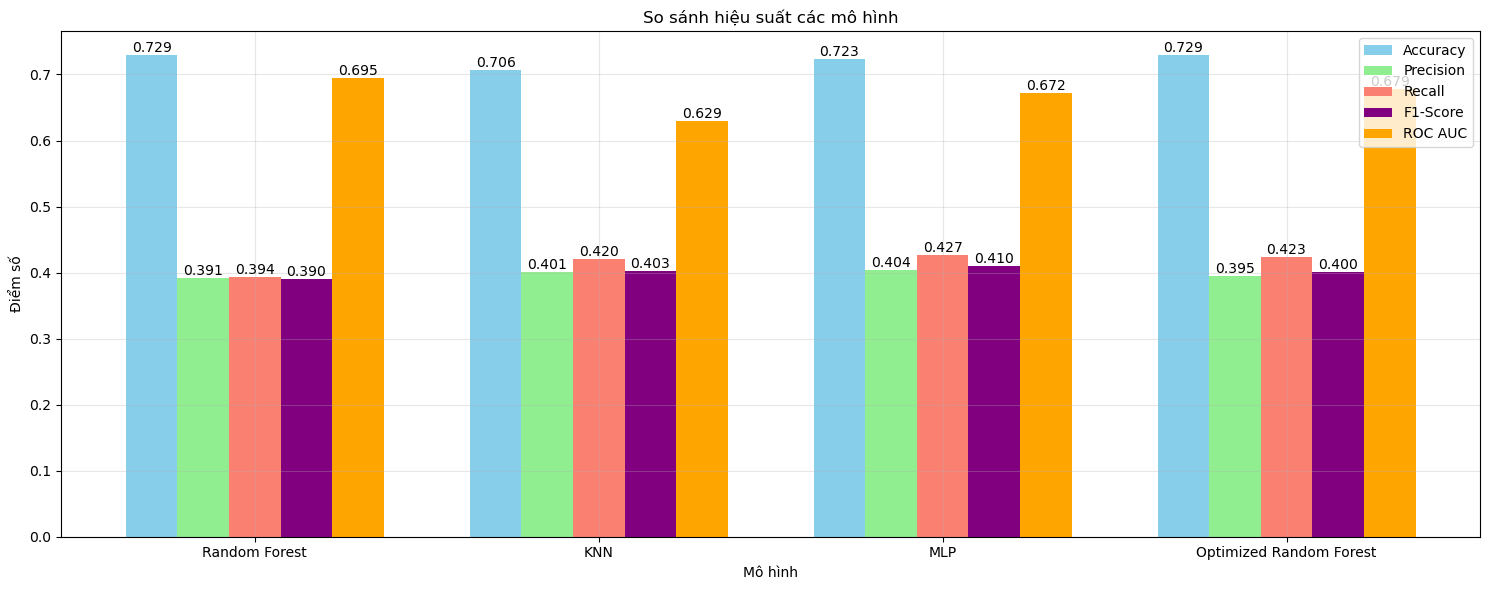

In [217]:
# So sánh các mô hình
comparison_results = compare_models(org_models, scaled_X, y_true)

In [218]:
comparison_results

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,Precision-class0,Precision-class1,Precision-class2,Recall-class0,Recall-class1,Recall-class2,F1-class0,F1-class1,F1-class2
0,Random Forest,0.7293,0.3913,0.3937,0.3904,0.6952,0.8592,0.0296,0.2850,0.8266,0.0623,0.2923,0.8426,0.0401,0.2886
1,KNN,0.7064,0.4006,0.4201,0.4029,0.6289,0.8753,0.0354,0.2911,0.7817,0.0940,0.3846,0.8258,0.0514,0.3314
2,MLP,0.7234,0.4040,0.4270,0.4102,0.6722,0.8783,0.0406,0.2931,0.7959,0.0588,0.4264,0.8351,0.0481,0.3474
3,Optimized Random Forest,0.7291,0.3952,0.4235,0.4004,0.6786,0.8764,0.0226,0.2866,0.7975,0.0076,0.4653,0.8351,0.0114,0.3547
